# Example analysis notebook

In this notebook, we will go through the basics of: 

1. Load pre-processed data

2. Synchronize to behavioral data

3. Process the behavioral data 

4. Create epochs

5. Downsample the epoched data 

6. Look for IEDs (**automatic** or manual) 

7. Save the epoched data 

8. Compute TFR and drop IED trials if you care about low frequencies. 

9. Plot

10. Example of statistical analyses (TODO)

The main point of this notebook is to make epoched data **CORRECTLY** as this will be the crux of many, many analyses in the future, and to provide tools for IED detection in epochs (both automatic and manual).

On IEDS: 

- Great images of interictal and ictal spiking: 

    1. https://pubmed.ncbi.nlm.nih.gov/32007920/
    
    2. https://www.sciencedirect.com/science/article/pii/S1059131119304200

- More on IEDs: 

    1. https://www.frontiersin.org/articles/10.3389/fnhum.2020.00044/full

    2. Why removing trials with IEDs might be important for generalizable conclusions about behavior: 
    
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3770206/
    
    https://academic.oup.com/cercorcomms/article/2/2/tgab019/6179205
    
- Especially for low frequencies (sub-gamma) this is important! "Low-frequency power remained elevated for several seconds following the IED... Low-frequency power was elevated and high-frequency power suppressed in pre-IED epochs compared with non-IED epochs."


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy
from scipy.stats import zscore, linregress
import pandas as pd
from mne.preprocessing.bads import _find_outliers

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append('/Users/christinamaher/Documents/Github/LFPAnalysis')


In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils


## Loading pre-processed data

It's a good idea to setup a sensible directory structure like below. Note that all my data lives on '/sc/arion' which is Minerva. 



In [ ]:
base_dir = '/Users/christinamaher/Desktop' # this is the root directory for most un-archived data and results 

save_dir = f'{base_dir}/MS012'  # save intermediate results in the 'work' directory
    
# I have saved most of my raw data in the 'projects directory'
behav_dir = f'{base_dir}/MS009/Behavior'
neural_dir = f'{base_dir}/MS009/Ephys'
anat_dir = f'{base_dir}/MS009/Anat'


Let's load in the re-referenced data, the photodiode data for synchronization, and the electrode dataframe

In [ ]:
wm_ref_data = mne.io.read_raw_fif('/Users/christinamaher/Desktop/MS012/wm_ref_ieeg.fif', preload=True)
anode_list = [x.split('-')[0] for x in wm_ref_data.ch_names]

In [ ]:
len(anode_list)

In [ ]:
wm_ref_data._data.shape

In [ ]:
wm_ref_data = mne.io.read_raw_fif('/Users/christinamaher/Desktop/MS009/wm_ref_ieeg.fif', preload=True)
anode_list = [x.split('-')[0] for x in wm_ref_data.ch_names]
photodiode = mne.io.read_raw_fif('/Users/christinamaher/Desktop/MS009/photodiode.fif', preload=True)

csv_files = glob(f'{anat_dir}/MS009_labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_df = elec_locs[elec_locs.NMMlabel.str.lower().isin(anode_list)]

#del wm_ref_data.ch_names[0]
#wm_ref_data._data = np.delete(wm_ref_data._data, 0, axis=0)

elec_df['NMMlabel'] = wm_ref_data.ch_names


In [ ]:
# Utility functions for image memorability ratings. 
import pandas as pd 
import numpy as np 
import os 
from scipy.stats import norm, zscore, linregress

In [ ]:
# load behavior data and save timestamp(s) of interest as variable 
behavior = pd.read_csv(r"/Users/christinamaher/Desktop/MS009/Behavior/MS009_clean.csv")
choice_ts = np.array(behavior['choice_ts'])
choice_ts = choice_ts * 1.024

# this command sets the backend so that the plots are interactive
%matplotlib qt

In [ ]:
# plot photodiode
plt.plot(photodiode._data[0])
plt.xlabel("Time")
plt.ylabel("V")
plt.title("Photodiode")

zeros = np.array([0.05] * len(choice_ts))
x_ts = choice_ts
y_ts = zeros.T
plt.scatter(x_ts,y_ts,color='red')

plt.show()

In [ ]:
# Compute offset between ts and photodiode and replot to verify alignment 
button_press = choice_ts[0]
#photodiode_deflection = 1.787e+05 #--> MS028
#photodiode_deflection = 2.493e+05 --> MS027
#photodiode_deflection = 2.16493e+06 --> MS026
#photodiode_deflection = 1.51902e+06 --> MS024
# photodiode_deflection = 2.1747e+06 --> MS019
#photodiode_deflection = 1.15661e06 --> MS017
# photodiode_deflection = 7.9698e+05 --> MS014
#photodiode_deflection = 7.3975e+05 #--> MS012
photodiode_deflection = 7.8683e+05 #--> MS009
offset = button_press - photodiode_deflection
choice_ts = choice_ts - offset
x_ts = choice_ts

In [ ]:
plt.close()
plt.plot(photodiode._data[0])
plt.scatter(x_ts,y_ts,color='green')
plt.show()

In [ ]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

feedback_post = 1.5 # this is the time the feedback is present 

choice_pre = 1.0 # this is the choice deliberation period
choice_post = 1.0

In [ ]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'choice_ts': [-1.0, 1.0],
       'iti_ts': [0, 0.5]}

epochs_all_evs = {f'{x}': np.nan for x in evs}

In [ ]:
# Example - make feedback events 
evs = (choice_ts / 1.024) / 1000 # ts in samples  

durs = np.zeros_like(choice_ts).tolist()

descriptions = ['choice_ts']*len(choice_ts)

# Make mne annotations based on these descriptions
annot = mne.Annotations(onset=evs,
                          duration=durs,
                          description=descriptions)

wm_ref_data.set_annotations(annot)

events_from_annot, event_dict = mne.events_from_annotations(wm_ref_data)

epochs = mne.Epochs(wm_ref_data, 
                    events_from_annot, 
                    event_id=event_dict, 
                    baseline = None, # never baseline within mne functions
                    tmin=-(buf + choice_pre), 
                    tmax=buf + choice_post, 
                    reject=None, 
                    reject_by_annotation=False,
                    preload=True)

new_metadata = pd.DataFrame(data=['complete'] * len(epochs), columns=['bar'],
                            index=range(len(epochs)))
epochs.metadata = new_metadata

epochs_all_evs['choice_ts'] = epochs

In [ ]:
evs = ((choice_ts / 1.024) / 1000) + 1.5 # this is the start of the inter-trial interval. 

durs = np.zeros_like(choice_ts).tolist()

descriptions = ['iti_ts']*len(choice_ts)

# Make mne annotations based on these descriptions
annot_baseline = mne.Annotations(onset=evs,
                          duration=durs,
                          description=descriptions)

wm_ref_data.set_annotations(annot_baseline)

events_from_annot, event_dict = mne.events_from_annotations(wm_ref_data)
events_from_annot

baseline_epochs = mne.Epochs(wm_ref_data, 
                    events_from_annot, 
                    event_id=event_dict, 
                    tmin=-(buf+0), 
                    tmax=(buf+0.50), 
                    reject=None, 
                    reject_by_annotation=False,
                    preload=True)

new_metadata = pd.DataFrame(data=['complete'] * len(epochs), columns=['bar'],
                            index=range(len(epochs))) # you have to add metadata 
baseline_epochs.metadata = new_metadata

epochs_all_evs['iti_ts'] = baseline_epochs

In [ ]:
choice_metadata = epochs_all_evs['choice_ts'].metadata.copy()
choice_metadata['reward'] = behavior['r'].tolist()
choice_metadata['ev'] = behavior['ev'].tolist()
choice_metadata['relevant_dimension'] = behavior['rd_numeric'].tolist()
choice_metadata['acquired'] = behavior['acquired'].tolist()
choice_metadata['rpe'] = behavior['rpe'].tolist()
choice_metadata['condition'] = behavior['condition'].tolist()
#choice_metadata['all_epochs'] = behavior['all_epochs'].tolist() - need to manually add this column to everyone after MS009
epochs_all_evs['choice_ts'].metadata = choice_metadata

iti_metadata = epochs_all_evs['iti_ts'].metadata.copy()
iti_metadata['reward'] = behavior['r'].tolist()
iti_metadata['ev'] = behavior['ev'].tolist()
iti_metadata['relevant_dimension'] = behavior['rd_numeric'].tolist()
iti_metadata['acquired'] = behavior['acquired'].tolist()
iti_metadata['rpe'] = behavior['rpe'].tolist()
choice_metadata['condition'] = behavior['condition'].tolist()
epochs_all_evs['iti_ts'].metadata = iti_metadata

In [ ]:
epochs_all_evs['iti_ts'].resample(sfreq=wm_ref_data.info['sfreq']/2)
epochs_all_evs['choice_ts'].resample(sfreq=wm_ref_data.info['sfreq']/2)

In [ ]:
# manually anotate interictal discharges
fig = epochs_all_evs['choice_ts'].plot(n_epochs=1, n_channels= 25)  

In [ ]:
# Need this following line to save the annotations to the epochs object 
fig.fake_keypress('a')

In [ ]:
# Check the epoch annotations 
epochs_all_evs['choice_ts'].get_annotations_per_epoch
epochs_all_evs['choice_ts'].drop_log

In [ ]:
# MSO009 DROPPED EPOCHS

epochs_all_evs['iti_ts'].drop(np.array([54, 60, 66, 70, 71, 78, 84, 85, 100, 136, 147, 148, 151, 155, 167, 192, 196, 197]), reason='USER', verbose=None)
epochs_all_evs['choice_ts'].drop(np.array([54, 60, 66, 70, 71, 78, 84, 85, 100, 136, 147, 148, 151, 155, 167, 192, 196, 197]), reason='USER', verbose=None)

In [ ]:
# MS012 DROPPED EPOCHS

epochs_all_evs['iti_ts'].drop(np.array([211]), reason='USER', verbose=None)
epochs_all_evs['choice_ts'].drop(np.array([211]), reason='USER', verbose=None)

In [ ]:
# MS014 DROPPED EPOCHS
epochs_all_evs['iti_ts'].drop(np.array([196, 197, 198, 199]), reason='USER', verbose=None)

In [ ]:
# MS017 DROPPED EPOCHS
epochs_all_evs['iti_ts'].drop(np.array([14, 18, 37, 38, 65, 66, 67, 80, 82, 83, 96, 97, 98, 108, 110, 111, 122, 123, 126, 127, 132, 134, 135, 136, 137, 160, 161, 183, 184, 185, 198, 199, 200]), reason='USER', verbose=None)

In [ ]:
# MS019 DROPPED EPOCHS
epochs_all_evs['iti_ts'].drop(np.array([7, 11, 27, 38, 47, 48, 52, 61, 73, 88, 97, 124, 125, 130, 168, 169, 174]), reason='USER', verbose=None)


In [ ]:
# MS024 DROPPED EPOCHS

epochs_all_evs['iti_ts'].drop(np.array([132, 139, 148, 170, 190, 208, 210, 213]), reason='USER', verbose=None)



In [ ]:
# MS026 DROPPED EPOCHS
epochs_all_evs['iti_ts'].drop(np.array([1, 2, 3, 4, 18, 39, 41, 44, 45, 51, 55, 68, 104, 123, 128]), reason='USER', verbose=None)

In [ ]:
#MS027 DROPPED EPOCHS
epochs_all_evs['iti_ts'].drop(np.array([32, 43, 53, 67, 81, 97, 99, 125, 137, 138, 152, 153, 167, 168, 176, 184, 205, 208, 214, 215]), reason='USER', verbose=None)


In [ ]:
#MS028 DROPPED EPOCHS
epochs_all_evs['iti_ts'].drop(np.array([]), reason='USER', verbose=None)


In [ ]:
# save epochs for plotting/stats
#epochs_all_evs.save(f'{save_dir}/epoch.fif', overwrite=True)

Wavelet TFR

In [ ]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['choice_ts']
baseline_ev = 'iti_ts'
evs = {'choice_ts': [-1.0, 1.0],
       'iti_ts': [0, 0.5]}
for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')

In [ ]:
# Set some spectrogram parameters 
subj_ids = ['MS012']

#reqs = np.arange(70,200,5)
freqs  = np.logspace(*np.log10([4,200]),num=40)

n_cycles = 4
sr = epochs_all_evs[baseline_ev].info['sfreq']
buf = 1.0
buf_ix = int(buf*sr)


baseline_power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

In [ ]:
# Compute baseline_power
for subj_id in subj_ids:
    event = 'iti_ts'
    epochs = epochs_all_evs[event]
        
    # Let's make sure we only do this for good channels
    good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                           epochs._data.shape[1], len(freqs), 
                           epochs._data.shape[-1]])

    for ch_ix in np.arange(epochs._data.shape[1]): 
        ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
        #bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
        #good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        #ch_data = np.delete(ch_data, bad_epochs, axis=0)
        good_epochs = np.arange(0,epochs._data.shape[0],1)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                            freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=1)

        pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

    temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                            epochs.times, freqs)
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    baseline_power_epochs[event] = temp_pow  


In [ ]:
for subj_id in subj_ids:
    for event in analysis_evs:
                
        epochs = epochs_all_evs[event]
            
        # Let's make sure we only do this for good channels
        good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
        picks = [x for x in good_chans]
        
        pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                               epochs._data.shape[1], len(freqs), 
                               epochs._data.shape[-1]])

        for ch_ix in np.arange(epochs._data.shape[1]): 
            ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
            #bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
            #good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
            #ch_data = np.delete(ch_data, bad_epochs, axis=0)
            good_epochs = np.arange(0,epochs._data.shape[0],1)
            ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                                use_fft=True, output='power', n_jobs=1)

            pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]
        
        temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                                epochs.times, freqs)
        
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
        baseline_corrected_power = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, 
                                      baseline_power_epochs['iti_ts'], mode='zscore',baseline_only=False)
        
        zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = epochs_all_evs[event].metadata
        
        power_epochs[event] = zpow
        

In [ ]:
region = 'middle frontal'
picks = analysis_utils.select_picks_rois(elec_df, region)
picks

In [ ]:
# rois = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']
#region = 'frontal orbital'
region = 'frontal orbital'

# band definitions for y-axis
#yticks =  [70, 100, 125, 150, 175] 
yticks =  [4, 30, 60, 120, 180] 

# task condition to contrast 
#conditions = ["(all_epochs == 1)"]
conditions = ["(acquired == 1)",
             "(acquired == 0)"]

cond_name = 'acquired'


for subj_id in subj_ids:
    #save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    # Get electrode df 
    # electrode files could either be csv or excel
    elec_files = glob(f'{anat_dir}/*.csv') + glob(f'{anat_dir}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    elec_data = lfp_preprocess_utils.load_elec(elec_file)

    anode_list = [x.split('-')[0] for x in epochs_all_evs[event].ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] = epochs_all_evs[event].ch_names

    picks = analysis_utils.select_picks_rois(elec_df, region)
    print(picks)
    #picks = ['lmoif1-lmoif8'] #- plot just a single electrode 
    
    for event in analysis_evs:
        fig, ax = plt.subplots(1, 2, figsize=(10,3))
        for ix, cond in enumerate(conditions):
            # Set the times for 
            times = power_epochs[event].times
            plot_data = np.nanmean(np.nanmean(power_epochs[event][cond].copy().pick_channels(picks).data, axis=0), axis=0)

            im = ax[ix].imshow(plot_data,
                      extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation=None,
                      aspect='auto', origin='lower', cmap='RdBu_r', vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
            ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{region}_{cond}_{event}')
            fig.colorbar(im, ax=ax[ix])

Save as dataframe for regression analysis and run encoding vs non encoding script

In [ ]:
# subset just the hinted blocks so far
event = 'choice_ts'
data = power_epochs['choice_ts']['condition == "hint"'].to_data_frame()
#data.to_csv('/Users/christinamaher/Desktop/MS009/MS009_ephys_data.csv') # subset high gamma and take the average, grouping by time. 
data

In [ ]:
# includes binning for t-tests/regression
df2 = data.iloc[::100]
df2

In [ ]:
df3 = df2.loc[data['freq'] >= 70]
df3

In [ ]:
# use this for taking continuous sampling of data - skips binning for permutation cluster testing
df3 = data.loc[data['freq'] >= 70]

In [ ]:
df4 = pd.melt(df3, id_vars=["time", "freq","epoch","condition"],var_name="electrode", value_name="power")
df4

In [ ]:
df4 = df4.drop('condition', axis=1)

In [ ]:
df4 = df4.drop('freq', axis=1)

In [ ]:
df4 = df4.loc[df4['electrode'] != 'research']
df4

In [ ]:
unique_names = df4['electrode'].nunique()
print(unique_names)  # output: 4

In [ ]:
average_by_epoch = df4.groupby(['time','epoch','electrode'])['power'].mean()

In [ ]:
# save data
#average_by_epoch.to_csv('/Users/christinamaher/Desktop/MS028/average_by_epoch.csv')

In [ ]:
# save anatomical info
#elec_df.to_csv('/Users/christinamaher/Desktop/MS028/elec_df.csv')

In [ ]:
# save regressor data 
#regressors = power_epochs['choice_ts']['condition == "hint"'].metadata
#regressors.to_csv('/Users/christinamaher/Desktop/MS028/regressors.csv')

Determine encoding electrodes by region

In [ ]:
import pandas as pd
data = pd.read_csv('/Users/christinamaher/Desktop/MS014/average_by_epoch.csv')
elec = pd.read_csv('/Users/christinamaher/Desktop/MS014/elec_df.csv')

In [ ]:
merged_df = pd.merge(data, elec, on='electrode')

In [ ]:
merged_df

In [ ]:
merged_df = merged_df.loc[merged_df['Bins'] != 'wm']

In [ ]:
merged_df

In [ ]:
merged_df.to_csv('/Users/christinamaher/Desktop/MS014/merged_df.csv')

In [ ]:
patient_data

In [ ]:
import mne
import pandas as pd
patient_data = pd.read_csv('/Users/christinamaher/Desktop/MS009/merged_df.csv')
encoding_elec = []
electrode_name = []
patient_name = []

In [6]:
#average_by_epoch.to_csv('/Users/christinamaher/Desktop/MS012/permutation_df.csv')
average_by_epoch = pd.read_csv('/Users/christinamaher/Desktop/MS012/permutation_df.csv')
electrode_list = average_by_epoch['electrode'].unique()
electrode_list

array(['racas1-rmolf3', 'racas10-rals11', 'racas2-rmolf3',
       'racas3-racas7', 'racas5-rals8', 'racas6-rals8', 'racas9-rals11',
       'raglt1-raglt6', 'raglt2-raglt6', 'raglt3-raglt6', 'raglt7-raglt6',
       'raglt9-raglt6', 'rals1-raglt5', 'rals10-rals12', 'rals13-rmcms7',
       'rals14-rmcms7', 'rals2-rmolf6', 'rals3-rmolf8', 'rals4-rals7',
       'rals9-rals7', 'rhplt1-raglt5', 'rhplt2-raglt5', 'rhplt3-raglt4',
       'rhplt8-rhplt6', 'rhplt9-rhplt6', 'rmcms4-rmcms2', 'rmcms8-rmcms6',
       'rmcms9-rmcms6', 'rmls1-rhplt4', 'rmls10-rmls6', 'rmls11-rmls7',
       'rmls2-rmls5', 'rmls3-rpls17', 'rmls4-rpls17', 'rmls8-rmls6',
       'rmls9-rmls6', 'rmolf1-rmolf6', 'rmolf10-rmolf9', 'rmolf11-rmolf9',
       'rmolf2-rmolf6', 'rmolf4-rmolf6', 'rmolf5-rmolf7', 'rmtpt1-rpls17',
       'rmtpt2-rmtpt6', 'rmtpt3-rmtpt5', 'rmtpt4-rmtpt5', 'rmtpt9-rmtpt8',
       'rpls11-rhplt4', 'rpls114-rpls113', 'rpls115-rpls113',
       'rpls116-rpls113', 'rpls12-raglt5', 'rpls13-raglt5',
       'rpls

In [97]:
### RUN THE PERMUTATION CLUSTER TEST - adapt so this runs as a loop
elec_num = np.where(electrode_list == 'rmolf11-rmolf9')[0][0]
e = electrode_list[elec_num]
electrode_data = average_by_epoch[average_by_epoch["electrode"] == e]
data_temp = (electrode_data.pivot(index='epoch', columns='time', values='power')).to_numpy()
F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(data_temp,tail=0)
cluster_p_values

Using a threshold of 1.982597
stat_fun(H1): min=-5.522106 max=4.425137
Running initial clustering …
Found 38 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

array([9.88281250e-01, 1.00000000e+00, 9.76562500e-04, 2.10937500e-01,
       1.00000000e+00, 9.58984375e-01, 9.01367188e-01, 9.92187500e-01,
       9.57031250e-01, 9.99023438e-01, 6.55273438e-01, 9.99023438e-01,
       9.98046875e-01, 9.18945312e-01, 9.70703125e-01, 9.76562500e-04,
       9.91210938e-01, 9.99023438e-01, 4.82421875e-01, 1.00000000e+00,
       1.00000000e+00, 7.81250000e-03, 9.63867188e-01, 3.33984375e-01,
       8.77929688e-01, 9.87304688e-01, 2.02148438e-01, 8.96484375e-01,
       9.90234375e-01, 9.98046875e-01, 9.98046875e-01, 6.42578125e-01,
       9.98046875e-01, 1.00000000e+00, 2.92968750e-02, 9.97070312e-01,
       9.99023438e-01, 1.00000000e+00])

In [101]:
np.where(cluster_p_values<0.05)

(array([ 2, 15, 21, 34]),)

In [105]:
clusters[34]

(array([936, 937, 938, 939, 940, 941, 942, 943, 944]),)

clusters[41]

In [98]:
mean_values = electrode_data.groupby('time')['power'].mean()
mean_values = mean_values.to_frame()
mean_values.reset_index(level=0, inplace=True)
mean_values

,time,power
0,-1.000000,0.009762
1,-0.998047,-0.176185
2,-0.996094,-0.407853
3,-0.994141,-0.557753
4,-0.992188,-0.569187
...,...,...
1020,0.992188,-0.385954
1021,0.994141,-0.354599
1022,0.996094,-0.268575
1023,0.998047,-0.178814


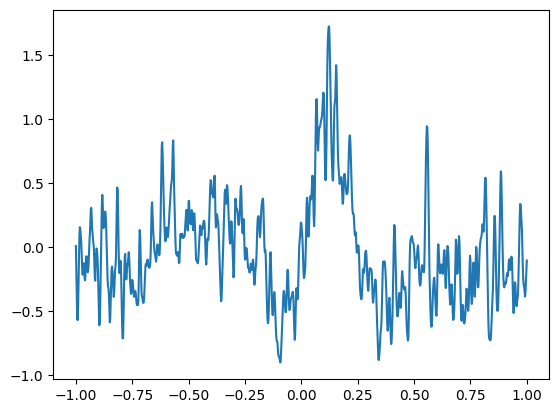

In [100]:
plt.plot(mean_values['time'],mean_values['power'])


In [112]:
# Define the x-values and the y-limits for shading
x_shade = indices
y_lower = np.zeros_like(x_shade)
y_upper = mean_values['power'][indices]
y_lower
#y_upper

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

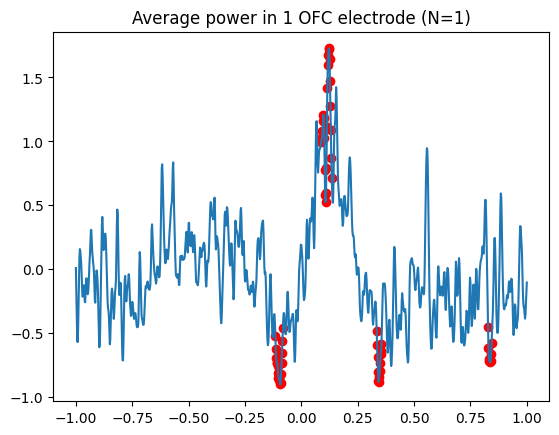

In [114]:
plt.plot(mean_values['time'],mean_values['power'])

indices = [557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569,
        570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581,453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
        466, 467, 468, 469, 470,683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694,936, 937, 938, 939, 940, 941, 942, 943, 944]
plt.title('Average power in 1 OFC electrode (N=1)')
plt.scatter(mean_values['time'][indices],mean_values['power'][indices], color="red")

In [ ]:
# average across epochs for plottings
avg_power = electrode_data.groupby('time').agg({'power': 'mean'})
avg_power = avg_power['power']

In [ ]:
# RUN PERMUTATION TEST AS A LOOP
#import mne
#patient_data = pd.read_csv('/Users/christinamaher/Desktop/MS028/merged_df.csv')
#encoding_elec = []
#electrode_name = []
#patient_name = []

#electrode_list = patient_data.electrode.unique()
for e in electrode_list:
    electrode_data = patient_data[patient_data["electrode"] == e]
    data_temp = (electrode_data.pivot(index='epoch', columns='time', values='power')).to_numpy()
    F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(data_temp, out_type='mask', tail=0)
    if len(clusters) > 0:
        encoding = 1
    else:
        encoding = 0
        
    encoding_elec.append(encoding) # save data so that encoding versus non-encoding electrodes can be subset
    electrode_name.append(e)

In [ ]:
encoding_results = pd.DataFrame({'encoding': encoding_elec, 'elec': electrode_name})

In [ ]:
encoding_results.to_csv('/Users/christinamaher/Desktop/MS028/encoding_results.csv')

In [ ]:
import pandas as pd

In [ ]:
encoding = pd.read_csv('/Users/christinamaher/Desktop/MS012/encoding_results.csv')
merged = pd.read_csv('/Users/christinamaher/Desktop/MS012/merged_df.csv')
repeat_number = len(merged[merged["electrode"] == merged["electrode"][0]])

n_repeats = repeat_number
x = encoding['encoding'].repeat(n_repeats).reset_index(drop=True)

merged['encoding'] = x
merged.to_csv('/Users/christinamaher/Desktop/MS012/merged_encoding.csv')

In [ ]:
data = pd.read_csv('/Users/christinamaher/Desktop/MS028/merged_encoding.csv')
data

In [ ]:
ofc_df = data.loc[(data['Bins'] == 'OFC') & (data['encoding'] == 1)]
pfc_df = data.loc[(data['Bins'] == 'lPFC') & (data['encoding'] == 1)]

In [ ]:
regressors = pd.read_csv('/Users/christinamaher/Desktop/MS012/regressors.csv')
regressors
regressors = regressors.drop('Unnamed: 0', axis=1)

In [ ]:
repeated_df_ofc = pd.concat([regressors]*int(ofc_df.shape[0]/regressors.shape[0]),ignore_index=True)
repeated_df_pfc = pd.concat([regressors]*int(pfc_df.shape[0]/regressors.shape[0]),ignore_index=True)

In [ ]:
repeated_df_ofc

In [ ]:
ofc_df.to_csv('/Users/christinamaher/Desktop/MS012/ofc_df_beta.csv')
pfc_df.to_csv('/Users/christinamaher/Desktop/MS012/pfc_df_beta.csv')
repeated_df_ofc.to_csv('/Users/christinamaher/Desktop/MS012/repeated_df_ofc_beta.csv')
repeated_df_pfc.to_csv('/Users/christinamaher/Desktop/MS012/repeated_df_pfc_beta.csv')